## A simple Autoencoder to be trained on GPU/CPU 

### Aimed at compressing Stokes I (for now) for synthesized observed photospheric spectral lines 

### various training and validation sets available at: 

https://drive.google.com/drive/folders/1SO4FyyX_X878FAcU7k1zD6AkOvFyWMH4?usp=sharing

In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# We are going to make a dense autoencoder here:


class dense_ae(nn.Module):
    def __init__(self, inputsize, bottleneck):
        super(dense_ae, self).__init__()
        self.linear1 = nn.Linear(inputsize,60)
        self.linear2 = nn.Linear(60,30)
        #self.linear3 = nn.Linear(80,40)
        #self.linear4 = nn.Linear(40,20)
        self.linear5 = nn.Linear(30, bottleneck)
        
        self.linear6 = nn.Linear(bottleneck,30)
        self.linear7 = nn.Linear(30,60)
        #self.linear8 = nn.Linear(40,80)
        #self.linear9 = nn.Linear(80,80)
        self.linear10 = nn.Linear(60,inputsize)
        
        self.activation = nn.ReLU()
        self.activationS = nn.Sigmoid()
        
        self.bn_1i = nn.BatchNorm1d(60)
        self.bn_2i = nn.BatchNorm1d(30)
        self.bn_3i = nn.BatchNorm1d(bottleneck)
        self.bn_bottleneck = nn.BatchNorm1d(bottleneck)
        
        self.bn_1o = nn.BatchNorm1d(30)
        self.bn_2o = nn.BatchNorm1d(60)
        #self.bn_3o = nn.BatchNorm1d(bottleneck)
        
        self.dropout05 = nn.Dropout(0.5)
        
        
        
    def encode(self,x):
        
        out = self.linear1(x)
        out = self.activation(out)
        
        out = self.linear2(out)
        out = self.activation(out)
        
        out = self.linear5(out)
        out = self.activationS(out)
        
        return out;
        
    def decode(self,x):
        
        out = self.linear6(x)
        out = self.activation(out)
        
        out = self.linear7(out)
        out = self.activation(out)
        
        out = self.linear10(out)
        out = self.activationS(out)
        
        return out;
        
    def forward(self, x):
        
        compressed = self.encode(x);
        restored   = self.decode(compressed);
        
        return restored;
    
def make_model(cudaoption, inputsize, bottleneck):
    
    model = dense_ae(inputsize, bottleneck)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

def model_encode(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.encode(inputdata)
    
    output = output.to("cpu")
    return output

def model_decode(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.decode(inputdata)
    
    output = output.to("cpu")
    return output

## Let's make a function to train:

def compilefit(model, data_in, data_out, data_val_in, data_val_out, nepochs, criterion, cudaoption, lri, output_interval, batch, weight_decayi, w):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri, weight_decay = weight_decayi)
    loss_fn = nn.MSELoss()
    loss_val_fn = nn.MSELoss()
    
    if cudaoption:
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        data_val_in = data_val_in.to(device)
        data_val_out = data_val_out.to(device)
        
        w = w.to(device)
        
        
    performance = np.zeros([2,nepochs])
    
    #N_data = len(data[:,0])
    #N_batches = N_data // batch
            
    for i in range(0,nepochs):
        
        #indices = np.arange(N_data)
        #indices = np.random.permutation(indices)
        
        #for j in range(0, N_batches):
            
        #data_batch = data[j*batch:(j+1)*batch,:]
        
        
        optimizer.zero_grad()
        out = model.forward(data_in)
        loss = loss_fn(data_out / w[None,:],out / w[None,:])
        #loss = loss_fn(data_out, out)
        loss.backward()
        optimizer.step()
        performance[0,i] = loss.item()
        
        # Validation:
        out_val = model.forward(data_val_in)
        loss_val = loss_val_fn(out_val / w[None,:], data_val_out / w[None,:])
        #loss_val = loss_val_fn(out_val, data_val_out)
        performance[1,i] = loss_val.item()
        
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - residual std : {np.sqrt(loss.item()):.6f} - val std : {np.sqrt(loss_val.item()):.6f}')
    return performance

In [3]:
# test for GPU:

cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0


In [4]:
ae_model = make_model(cudaoption, 112, 12)

[INFO] Cuda model: NVIDIA GeForce RTX 2060 with Max-Q Design
[INFO] Parameters in GPU: True


### Ok, creating the model and making sure GPU works is done, now let's see what happens with data.

In [5]:
from astropy.io import fits 

In [6]:
data = fits.open("C:/Data/Hinode_ML_compression/training_sample_5c_scala.fits")[0].data

In [7]:
data.shape

(150000, 112)

In [8]:
#del(stokes)

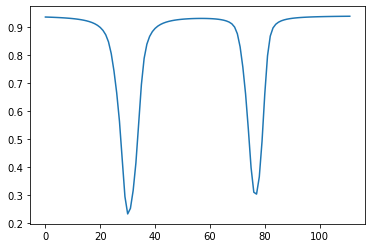

In [9]:
plt.plot(data[0])

In [10]:
data_norm = np.copy(data)

In [11]:
# Let's try with a normalization w.r.t. line core:
mean_spectrum = np.mean(data_norm,axis=(0))
w = np.sqrt(mean_spectrum)
w = torch.from_numpy(w.astype('float32'))

In [12]:
# If you want to normalize wavelength wise (not a good idea imho)

#for l in range(0,201):
#    data_norm[:,l] = (data[:,l] - np.amin(data[:,l])) / (np.amax(data[:,l])-np.amin(data[:,l]))
#data_norm[:,:] = data_norm[:,:] / mean_spectrum[None,:]

In [13]:
dmax = np.amax(data)
dmin = np.amin(data)

In [14]:
data_norm_in = data_norm + np.random.normal(0,2E-3,(150000,112))
data_norm_out = data_norm + np.random.normal(0,2E-3,(150000,112))
del(data_norm)

In [15]:
data_norm_in[:,:] = (data_norm_in[:,:] - dmin) / (dmax - dmin)
data_norm_out[:,:] = (data_norm_out[:,:] - dmin) / (dmax - dmin)

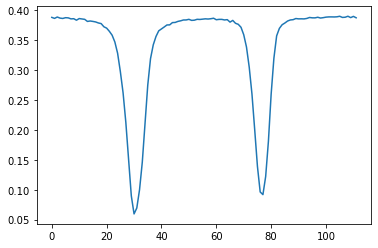

In [16]:
plt.plot(data_norm_in[0])

In [17]:
#data_torch = torch.from_numpy(data_norm.astype('float32'))
data_norm_in = torch.from_numpy(data_norm_in.astype('float32'))
data_norm_out = torch.from_numpy(data_norm_out.astype('float32'))

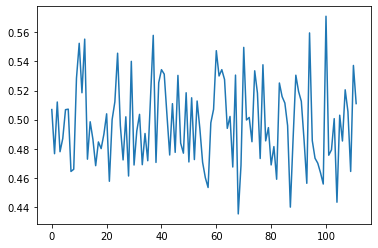

In [18]:
test_output = model_predict(ae_model,data_norm_in[:10],cudaoption)
test_output.shape
plt.plot(test_output[0].detach().numpy())

In [19]:
data_val = fits.open("C:/Data/Hinode_ML_compression/qs_ph_disk_center_synth_1_1_hinodewvl.fits")[0].data[:,:,0,:]
data_val = data_val.reshape(768*768, 112)
Nval = 10000
indices = (np.arange(Nval).astype('int'))
import random

random_sample  = random.sample(indices.tolist(),Nval)
data_val = data_val[random_sample,:]

print(data_val.shape)

data_val_in = data_val + np.random.normal(0,2E-3,(Nval,112))
data_val_in[:,:] = (data_val_in[:,:] - dmin) / (dmax - dmin)
data_val_in = torch.from_numpy(data_val_in.astype('float32'))

data_val_out = data_val + np.random.normal(0,2E-3,(Nval,112))
data_val_out[:,:] = (data_val_out[:,:] - dmin) / (dmax - dmin)
data_val_out = torch.from_numpy(data_val_out.astype('float32'))

(10000, 112)


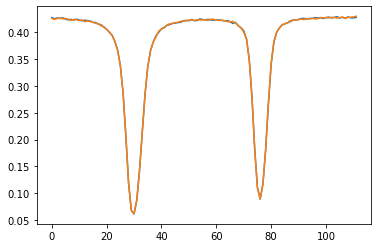

In [20]:
plt.plot(data_val_in[0,:])
plt.plot(data_val_out[0,:])

In [21]:
# Create model again as the above was just testing:
ae_model = make_model(cudaoption, 112, 8)

[INFO] Cuda model: NVIDIA GeForce RTX 2060 with Max-Q Design
[INFO] Parameters in GPU: True


In [22]:
#summary(ae_model,input_size=(1,112))

In [23]:
#convergence = compilefit(ae_model, data_torch, 1000, 0, cudaoption, 1E-2, 200, 256)
#convergence = compilefit(ae_model, data_torch, 5000, 0, cudaoption, 5E-3, 200, 256)
#convergence = compilefit(ae_model, data_norm_in, data_norm_out, 10000, 0, cudaoption, 2E-3, 200, 256)
convergence = compilefit(ae_model, data_norm_in, data_norm_out, data_val_in, data_val_out, 50000, 0, cudaoption, 5E-4, 200, 256, 0, w)

#convergence = compilefit(ae_model, data_norm_in, data_norm_out, 50000, 0, cudaoption, 5E-4, 200, 256, 1E-6)

 It : 200 - residual std : 0.085280 - val std : 0.077998
 It : 400 - residual std : 0.077734 - val std : 0.070415


KeyboardInterrupt: 

In [ ]:
torch.save(ae_model, 'hinode_encoding_8.pt')

In [ ]:
plt.figure(figsize=[10,6])
plt.semilogy(convergence[0],label='training loss') 
plt.semilogy(convergence[1], label = 'validation loss') 
plt.legend()

In [ ]:
#ae_model = make_model(cudaoption, 112, 12)
#convergence = compilefit(ae_model, data_norm_in, data_norm_out, 50000, 0, cudaoption, 1E-3, 200, 256, 1E-6)
#convergence = compilefit(ae_model, data_norm_in, data_norm_out, 50000, 0, cudaoption, 5E-4, 200, 256, 1E-6)
#torch.save(ae_model, 'hinode_encoding_10noisy_decay.pt')
#plt.figure(figsize=[10,6])

In [ ]:
#plt.figure(figsize=[10,6])
#plt.semilogy(convergence) 

In [24]:
del(data)
del(data_norm_in)
del(data_norm_out)

### Here we do some statistical analysis of the "compression"

In [ ]:
test_output = model_predict(ae_model,data_norm_in,cudaoption)

In [ ]:
data_reconstructed = test_output.detach().numpy()

In [ ]:
# de-normalize

data_reconstructed  = data_reconstructed * (dmax-dmin) + dmin

In [ ]:
noise = np.mean(data[:,0]) * 7E-3

residual = (data - data_reconstructed)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 201
print (np.mean(chisq))
print (np.median(chisq))

In [ ]:
plt.figure(figsize=[10,7])
plt.hist(chisq,bins=50,range=[0,5])

In [ ]:
# Example plots 

i = 1652

plt.figure(figsize=[10,6])
plt.plot(data[i], label = 'Original')
plt.plot(data_reconstructed[i], label = 'Compressed')
plt.legend()

### Simple validation here:

In [62]:
ae_model = torch.load('hinode_encoding_6.pt')

In [63]:
data_val = fits.open("C:/Data/Hinode_ML_compression/qs_ph_disk_center_synth_1_1_hinodewvl.fits")[0].data

In [64]:
data_val = data_val[:,:,0,:].reshape(768*768, 112)

In [65]:
noise = np.mean(data_val[:,0]) * 7E-3
print (noise)

0.007173758002705964


In [66]:
data_val += np.random.normal(0,noise, (768*768, 112))

In [67]:
data_val = (data_val - dmin) / (dmax-dmin)

In [68]:
data_val = torch.from_numpy(data_val.astype('float32'))

In [69]:
data_val_predicted = model_predict(ae_model,data_val, cudaoption)

In [70]:
data_val_predicted = data_val_predicted.detach().numpy()
data_val = data_val.detach().numpy()

In [71]:
data_val_predicted = data_val_predicted * (dmax-dmin) + dmin
data_val = data_val * (dmax-dmin) + dmin

In [72]:


residual = (data_val - data_val_predicted)
residual /= noise
residual = residual**2.0
print (len(residual))
chisqval = np.sum(residual,axis=1) / 112
print (np.mean(chisqval))
print (np.median(chisqval))

589824
2.3165448
1.7339921


In [73]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.2300e+02,
        4.6430e+03, 2.4778e+04, 5.7234e+04, 7.6720e+04, 7.5955e+04,
        6.5004e+04, 5.2568e+04, 4.1150e+04, 3.2253e+04, 2.5053e+04,
        2.0359e+04, 1.6446e+04, 1.3085e+04, 1.0948e+04, 8.8460e+03,
        7.6110e+03, 6.1570e+03, 5.3650e+03, 4.4490e+03, 3.9090e+03,
        3.1860e+03, 2.7730e+03, 2.4260e+03, 2.1330e+03, 1.7750e+03,
        1.6150e+03, 1.3910e+03, 1.3060e+03, 1.1430e+03, 9.8100e+02,
        9.3800e+02, 8.0200e+02, 7.2400e+02, 6.8500e+02, 6.3900e+02,
        5.6900e+02, 5.0900e+02, 5.0100e+02, 4.6700e+02, 4.2100e+02,
        3.7700e+02, 3.9100e+02, 3.3100e+02, 3.3300e+02, 3.1500e+02]),
 array([0.  , 0.16, 0.32, 0.48, 0.64, 0.8 , 0.96, 1.12, 1.28, 1.44, 1.6 ,
        1.76, 1.92, 2.08, 2.24, 2.4 , 2.56, 2.72, 2.88, 3.04, 3.2 , 3.36,
        3.52, 3.68, 3.84, 4.  , 4.16, 4.32, 4.48, 4.64, 4.8 , 4.96, 5.12,
        5.28, 5.44, 5.6 , 5.76, 5.92, 6.08, 6.24, 6.4 , 6.56, 6.72, 6.88,
        7.04, 7.2 , 7.

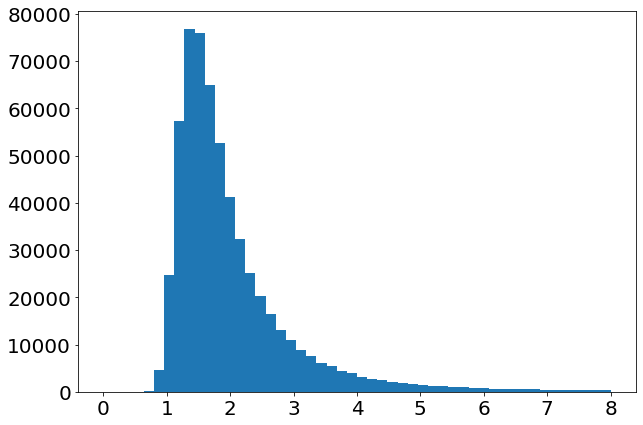

In [74]:
plt.figure(figsize=[10,7])
plt.hist(chisqval.flatten(),bins=50,range=[0,8])

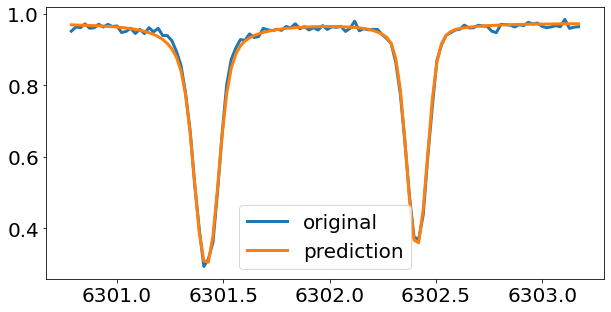

In [80]:
# Example plots 

llambda = np.linspace(0,111,112) - 56.5
llambda *= 0.0215 
llambda += 6302

i = 13156

plt.figure(figsize=[10,5])
plt.plot(llambda, data_val[i],label='original', lw=3)
plt.plot(llambda, data_val_predicted[i], label = 'prediction', lw=3)
plt.legend()
#plt.tight_layout()
plt.savefig('output.png', bbox_inches = 'tight')

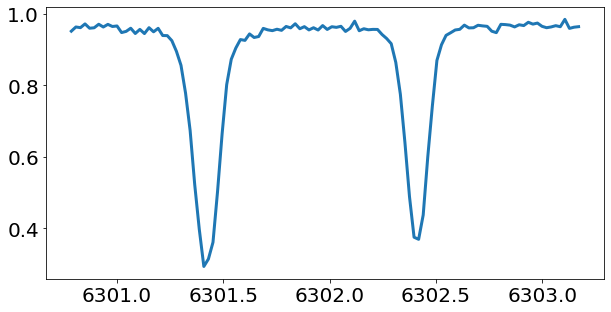

In [81]:
plt.figure(figsize=[10,5])
plt.plot(llambda, data_val[i],label='original', lw=3)
#plt.plot(llambda, data_val_predicted[i], label = 'prediction', lw=3)
#plt.tight_layout()
plt.savefig('input.png', bbox_inches = 'tight')

In [35]:
data_val = torch.from_numpy(data_val.astype('float32'))
data_val_compressed = model_encode(ae_model,data_val, cudaoption)

In [36]:
data_val_compressed = data_val_compressed.detach().numpy()

In [37]:
data_val_compressed = data_val_compressed.reshape(768,768,6)


In [38]:
atmos = fits.open("C:/Data/Hinode_ML_compression/qs_ph_disk_center_1_1_tau.fits")[0].data


In [39]:
atmos = atmos.transpose(0,2,3,1)

In [40]:
print (atmos[0,0,0])

[ 1.5  1.4  1.3  1.2  1.1  1.   0.9  0.8  0.7  0.6  0.5  0.4  0.3  0.2
  0.1  0.  -0.1 -0.2 -0.3 -0.4 -0.5 -0.6 -0.7 -0.8 -0.9 -1.  -1.1 -1.2
 -1.3 -1.4 -1.5 -1.6 -1.7 -1.8 -1.9 -2.  -2.1 -2.2 -2.3 -2.4 -2.5 -2.6
 -2.7 -2.8 -2.9 -3.  -3.1 -3.2 -3.3 -3.4 -3.5 -3.6 -3.7 -3.8 -3.9 -4.
 -4.1 -4.2 -4.3 -4.4 -4.5 -4.6 -4.7 -4.8 -4.9 -5.  -5.1 -5.2 -5.3 -5.4
 -5.5]


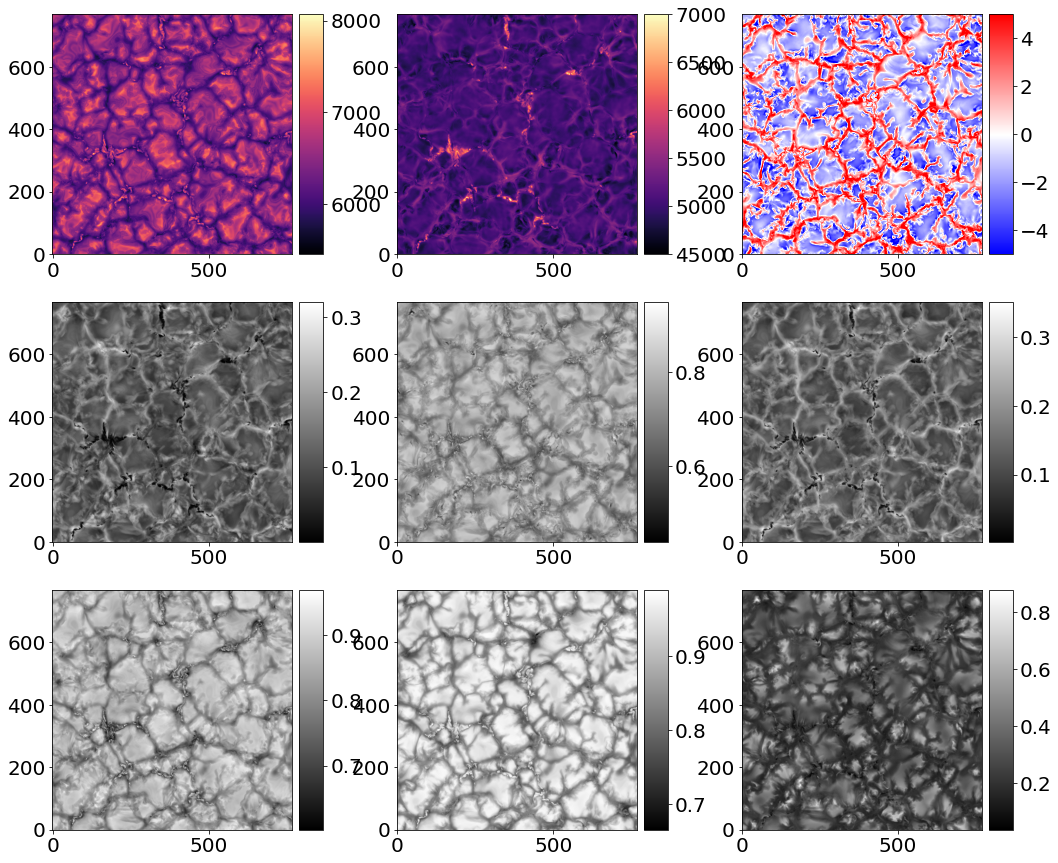

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(3, 3, figsize=[17.5, 15.0])

axes = axes.flatten()

im = axes[0].imshow(atmos[1,:,:,15].T, origin='lower',cmap = 'magma')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(atmos[1,:,:,25].T, origin='lower',cmap = 'magma',vmin=4500,vmax=7000)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(atmos[5,:,:,15].T/ (1E5), origin='lower',cmap = 'bwr',vmin = -5, vmax= 5)
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')


for i in range(3,9):
    
    im = axes[i].imshow(data_val_compressed[:,:,i-3].T, cmap = 'gray', origin = 'lower')
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='10%', pad=0.1)

    fig.colorbar(im, cax=cax, orientation='vertical')
    
fig.savefig("plt2.png",bbox_inches='tight')

In [42]:
del (data_val)
del(data_val_predicted)
del(data_val_compressed)

In [43]:
from scipy.stats import pearsonr

params = [atmos[1,:,:,15], atmos[1,:,:,25], atmos[1,:,:,35], atmos[5,:,:,15], atmos[5,:,:,25], atmos[5,:,:,35]]
params = np.asarray(params)

corr_matrix = np.zeros([6,6])

for i in range(0,6):
    for j in range(0,6):
        
        corr_matrix[i,j], _ = pearsonr(params[i,:,:].flatten(), data_val_compressed[:,:,j].flatten())

NameError: name 'data_val_compressed' is not defined

NameError: name 'data_val_compressed' is not defined

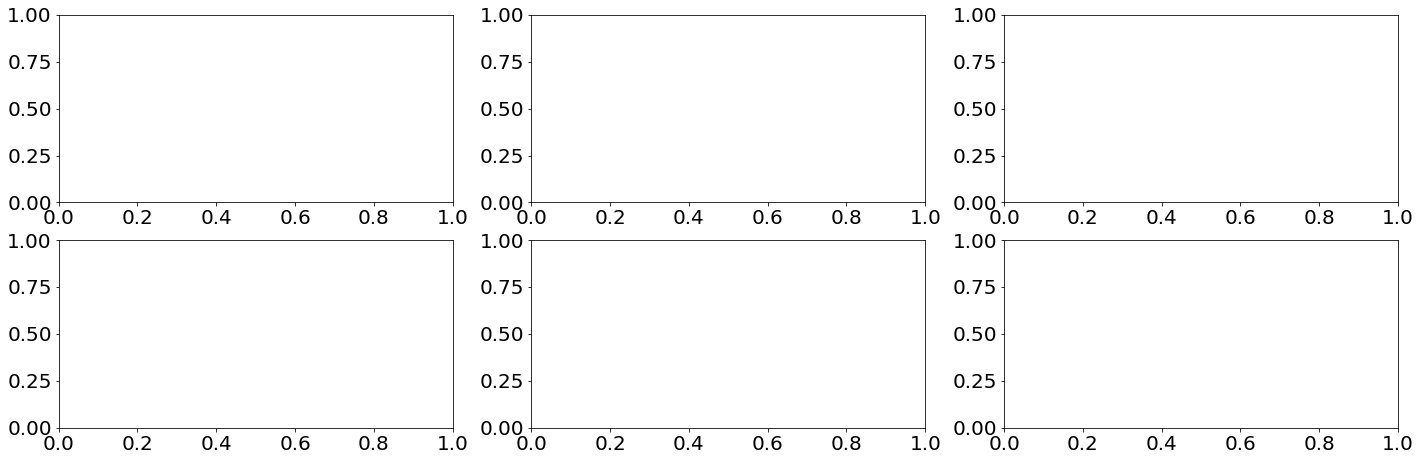

In [45]:
fig, axes = plt.subplots(2, 3, figsize=[24.0,7.6])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].hist(data_val_compressed[:,:,i].flatten(),bins=100,range=(0,1))
    
    #divider = make_axes_locatable(axes[i])
    #cax = divider.append_axes('right', size='10%', pad=0.1)

    #fig.colorbar(im, cax=cax, orientation='vertical')

## Here we apply it to the Lites cube!

In [47]:
obs_qs = fits.open("C:/Data/Hinode_ML_compression/lites_qs.fits")[0].data[:,:,0,:]

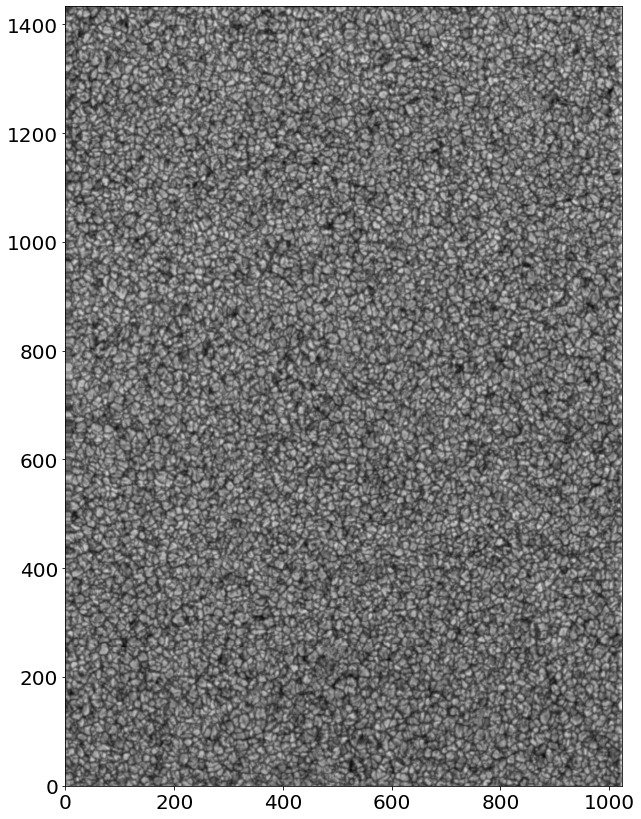

In [42]:
plt.figure(figsize=[10, 14.34])
plt.imshow(obs_qs[:,:1434,5].T, origin = 'lower', cmap = 'gray')
plt.savefig("liteqs_background.png", bbox_inches = 'tight')

In [48]:
obs_qs = obs_qs.astype('double')

In [49]:
mean_qs = np.mean(obs_qs, axis=(0,1))

In [50]:
obs_qs.shape

(1024, 2047, 112)

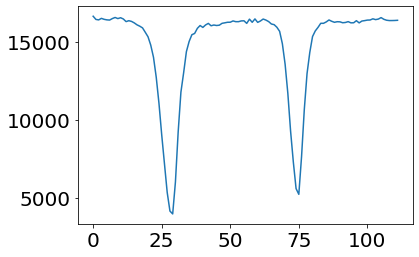

In [51]:
plt.plot(obs_qs[0,0])

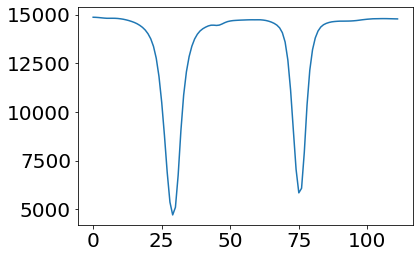

In [52]:
plt.plot(mean_qs)

In [53]:
qs_cont = np.mean(mean_qs[-10:])

In [54]:
obs_qs[:,:,:] = obs_qs / qs_cont

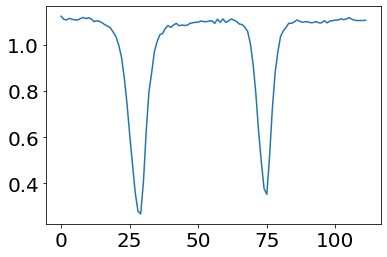

In [55]:
plt.plot(obs_qs[0,0])

In [56]:
obs_qs = obs_qs.reshape(-1,112)

In [57]:
obs_qs.shape

(2096128, 112)

In [58]:
obs_qs = (obs_qs - dmin) / (dmax-dmin)
obs_qs = torch.from_numpy(obs_qs.astype('float32'))
obs_qs_predicted = model_predict(ae_model,obs_qs, cudaoption)
obs_qs_predicted = obs_qs_predicted.detach().numpy()
obs_qs = obs_qs.detach().numpy()
obs_qs_predicted = obs_qs_predicted * (dmax-dmin) + dmin
obs_qs = obs_qs * (dmax-dmin) + dmin

residual = (obs_qs - obs_qs_predicted)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 112
print (np.mean(chisq))
print (np.median(chisq))

2096128
2.5483553
2.44553


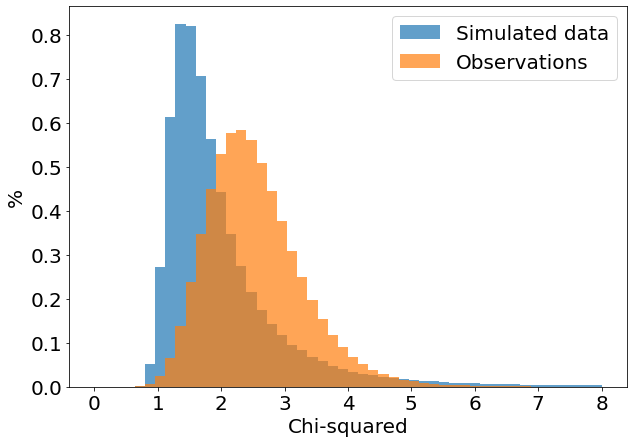

In [59]:
plt.figure(figsize=[10,7])
plt.hist(chisqval.flatten(),bins=50,range=[0,8],density = True, alpha=0.7, label = 'Simulated data')
plt.hist(chisq.flatten(),bins=50,range=[0,8],density = True, alpha=0.7, label = 'Observations')
plt.xlabel("Chi-squared")
plt.ylabel("%")
plt.legend()
plt.savefig("chisqcomp.png",bbox_inches = 'tight')

In [ ]:
obs_qs = torch.from_numpy(obs_qs.astype('float32'))


In [ ]:
obs_qs_compressed = model_encode(ae_model,obs_qs, cudaoption)
obs_qs_compressed = obs_qs_compressed.detach().numpy()
obs_qs_compressed = obs_qs_compressed.reshape(1024,2047,6)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(2, 3, figsize=[17.0,9])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].imshow(obs_qs_compressed[:512,:512,i].T, origin='lower', cmap='gray')
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='10%', pad=0.1)

    fig.colorbar(im, cax=cax, orientation='vertical')
    
plt.savefig("obs_compression.png",bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=[24.0,7.6])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].hist(obs_qs_compressed[:,:,i].flatten(),bins=100,range=(0,1))
    
    #divider = make_axes_locatable(axes[i])
    #cax = divider.append_axes('right', size='10%', pad=0.1)

    #fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
i = 86681

plt.figure(figsize=[10,6])
plt.plot(obs_qs[i],label='original')
plt.plot(obs_qs_predicted[i], label = 'compressed')
plt.legend()

## How does it compare with PCA?

In [ ]:
import numpy as np
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=6, batch_size=512)
ipca.fit(data_val.reshape(-1,112))


In [ ]:
data_val_ipca = ipca.transform(data_val.reshape(-1,112))

In [ ]:
data_val_ipca.shape

In [ ]:
data_val_restored = ipca.inverse_transform(data_val_ipca)


In [ ]:
data_val = data_val.detach().numpy()

In [ ]:
residual = (data_val - data_val_restored)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 112
print (np.mean(chisq))
print (np.median(chisq))

In [ ]:
data_val_ipca = data_val_ipca.reshape(768,768,6)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(2, 3, figsize=[17.5,9])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].imshow(data_val_ipca[:,:,i])
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='10%', pad=0.1)

    fig.colorbar(im, cax=cax, orientation='vertical')